In [1]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph

# Parameters

In [4]:
iteration = 2
PhenoGraph_k =  200
node_label = 'CellType'
Pattern_ids = [6]

# Subset 1

### Clinical

In [23]:
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical.head()


,Unnamed: 0,metabric_id,patient_id,Cohort,Overall Survival (Months),Overall Survival Status,Relapse Free Status (Months),Relapse Free Status,Chemotherapy,Radio Therapy,...,ERStatus,ERBB2_pos,Grade,sizeOrdinal,LymphNodesOrdinal,PAM50,isDiscovery,IntClust,Clinical Subtype,Subset_id
0,1,MB-0002,2,1.0,84.633333,0.0,83.52,0.0,NO,YES,...,pos,False,3.0,5-10mm,0,Luminal A,True,IntClust 4+,HR+/HER2-,2
1,2,MB-0005,5,1.0,163.700000,1.0,151.28,1.0,YES,NO,...,pos,False,2.0,10-20mm,1,Luminal B,True,IntClust 3,HR+/HER2-,2
2,3,MB-0006,6,1.0,164.933333,0.0,162.76,0.0,YES,YES,...,pos,False,2.0,20-50mm,2-3,Luminal B,True,IntClust 9,HR+/HER2-,1
3,5,MB-0010,10,1.0,7.800000,1.0,2.89,1.0,NO,YES,...,pos,False,3.0,20-50mm,0,Luminal B,True,IntClust 7,HR+/HER2-,1
4,6,MB-0014,14,1.0,164.333333,0.0,162.17,0.0,YES,YES,...,pos,False,2.0,5-10mm,1,Luminal B,True,IntClust 3,HR+/HER2-,1


### Histogram

In [24]:
SoftWL_dict = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            +'_'
            +str(node_label)
            + ".pkl",
        ),
        "rb",
    ),
)

Histograms = SoftWL_dict["Histogram"]
Patient_IDs = SoftWL_dict["Patient_id"]

### Presentation in 4 clinical subtypes

379 patients in total, 243 HR+/HER2-, 16 HR+/HER2+, 16 HR-/HER2+, 50 TNBC
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HR+/HER2- vs. HR+/HER2+: Mann-Whitney-Wilcoxon test two-sided, P_val:2.798e-04 U_stat=2.988e+03
HR+/HER2- vs. HR-/HER2+: Mann-Whitney-Wilcoxon test two-sided, P_val:5.390e-05 U_stat=3.102e+03
HR+/HER2- vs. TNBC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.106e-11 U_stat=9.700e+03
Pattern 6 in HR+/HER2- has 74% of patients
Pattern 6 in HR+/HER2+ has 44% of patients
Pattern 6 in HR-/HER2+ has 19% of patients
Pattern 6 in TNBC has 20% of patients


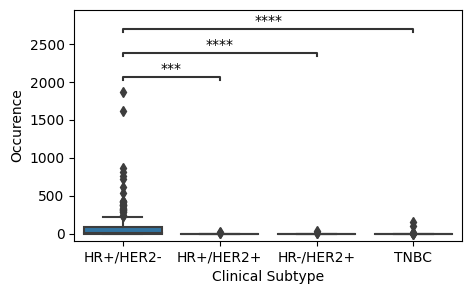

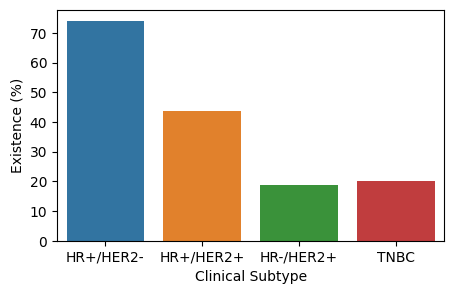

In [25]:
ER_status = np.array(
    [
        clinical.loc[clinical["patient_id"] == patient_id, "ER Status"].values[0]
        for patient_id in Patient_IDs
    ]
)
PR_status = np.array(
    [
        clinical.loc[clinical["patient_id"] == patient_id, "PR Status"].values[0]
        for patient_id in Patient_IDs
    ]
)
HER2_status = np.array(
    [
        clinical.loc[clinical["patient_id"] == patient_id, "HER2 Status"].values[0]
        for patient_id in Patient_IDs
    ]
)
Clinical_subtype = np.zeros(ER_status.shape, dtype=object)
for i in range(len(ER_status)):
    er = ER_status[i]
    pr = PR_status[i]
    her2 = HER2_status[i]
    if (er == "Positive" or pr == "Positive") and her2 == "Negative":
        Clinical_subtype[i] = "HR+/HER2-"
    elif (er == "Positive" or pr == "Positive") and her2 == "Positive":
        Clinical_subtype[i] = "HR+/HER2+"
    elif (er == "Negative" and pr == "Negative") and her2 == "Positive":
        Clinical_subtype[i] = "HR-/HER2+"
    elif (er == "Negative" and pr == "Negative") and her2 == "Negative":
        Clinical_subtype[i] = "TNBC"
print(
    "{} patients in total, {} HR+/HER2-, {} HR+/HER2+, {} HR-/HER2+, {} TNBC".format(
        len(Clinical_subtype),
        np.sum(Clinical_subtype == "HR+/HER2-"),
        np.sum(Clinical_subtype == "HR+/HER2+"),
        np.sum(Clinical_subtype == "HR-/HER2+"),
        np.sum(Clinical_subtype == "TNBC"),
    )
)

for pattern_id in Pattern_ids:
    histogram = Histograms[:, pattern_id - 1]
    DF_presentation = pd.DataFrame(
        {
            "Occurence": histogram,
            "Clinical Subtype": Clinical_subtype,
        }
    )
    DF_presentation = DF_presentation.loc[DF_presentation["Clinical Subtype"] != 0]
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(
        x="Clinical Subtype",
        y="Occurence",
        data=DF_presentation,
        showfliers=True,
        order=["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
    )
    from statannotations.Annotator import Annotator
    annot = Annotator(
        ax,
        [("HR+/HER2-", "HR+/HER2+"), ("HR+/HER2-", "HR-/HER2+"), ("HR+/HER2-", "TNBC")],
        data=DF_presentation,
        x="Clinical Subtype",
        y="Occurence",
        order=["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
    )
    annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
    annot.apply_test()
    ax, test_results = annot.annotate()

    DF_existence = pd.DataFrame(
        {
            "Clinical Subtype": ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
        }
    )
    for clinical_subtype in ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"]:
        data = DF_presentation.loc[
            DF_presentation["Clinical Subtype"] == clinical_subtype, "Occurence"
        ].values

        exisitence_ratio = np.sum(data > 0) / len(data)
        DF_existence.loc[
            DF_existence["Clinical Subtype"] == clinical_subtype, "Existence (%)"
        ] = (exisitence_ratio * 100)
        print(
            "Pattern {} in {} has {:.0f}% of patients".format(
                pattern_id, clinical_subtype, exisitence_ratio * 100
            )
        )
    f, ax = plt.subplots(figsize=(5, 3))
    sns.barplot(
        x="Clinical Subtype",
        y="Existence (%)",
        data=DF_existence,
        order=["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
    )

### K-M Plot

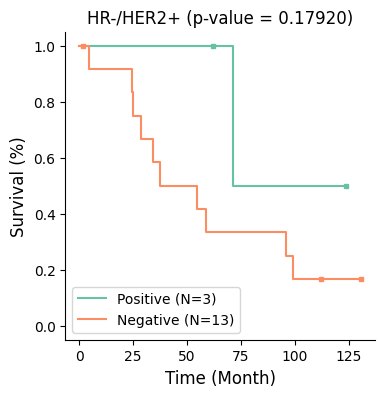

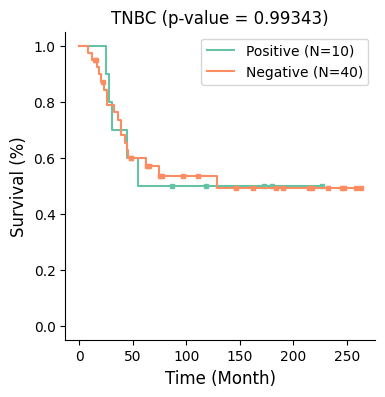

In [29]:
color_palette = sns.color_palette("Set2")
Length = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Disease-specific Survival (Months)"].values[0]
        for i in Patient_IDs
    ]
)
Status = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Disease-specific Survival Status"].values[0]
        for i in Patient_IDs
    ]
)

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

kmf = KaplanMeierFitter()
for clinical_subtype in ["HR-/HER2+", "TNBC"]:
    f, ax = plt.subplots(figsize=(4, 4))
    histogram = Histograms[:, Pattern_ids[0] - 1]
    length_A, event_observed_A = (
        Length[
            (Clinical_subtype == clinical_subtype)
            & (histogram > 0)
        ],
        Status[
            (Clinical_subtype == clinical_subtype)
            & (histogram > 0)
        ],
    )
    label = "Positive (N={})".format(len(length_A))
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[0],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

    length_B, event_observed_B = (
        Length[
            (Clinical_subtype == clinical_subtype)
            & (Histograms[:, Pattern_ids[0] - 1] == 0)
        ],
        Status[
            (Clinical_subtype == clinical_subtype)
            & (Histograms[:, Pattern_ids[0] - 1] == 0)
        ],
    )
    label = "Negative (N={})".format(len(length_B))
    kmf.fit(length_B, event_observed_B, label=label)
    kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[1],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )
    log_rank_test = multivariate_logrank_test(
        np.concatenate([length_A, length_B]),
        [0] * len(length_A) + [1] * len(length_B),
        np.concatenate([event_observed_A, event_observed_B]),
    )
    p_value = log_rank_test.p_value
    ax.legend(fontsize=10)
    ax.set_title("{} (p-value = {:.5f})".format(clinical_subtype, p_value), fontsize=12)
    ax.set_xlabel("Time (Month)", fontsize=12)
    ax.set_ylabel("Survival (%)", fontsize=12)
    ax.set(
        ylim=(-0.05, 1.05),
    )
    sns.despine()

# Subset 2

### Clinical

In [30]:
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical.head()


,Unnamed: 0,metabric_id,patient_id,Cohort,Overall Survival (Months),Overall Survival Status,Relapse Free Status (Months),Relapse Free Status,Chemotherapy,Radio Therapy,...,ERStatus,ERBB2_pos,Grade,sizeOrdinal,LymphNodesOrdinal,PAM50,isDiscovery,IntClust,Clinical Subtype,Subset_id
0,1,MB-0002,2,1.0,84.633333,0.0,83.52,0.0,NO,YES,...,pos,False,3.0,5-10mm,0,Luminal A,True,IntClust 4+,HR+/HER2-,2
1,2,MB-0005,5,1.0,163.700000,1.0,151.28,1.0,YES,NO,...,pos,False,2.0,10-20mm,1,Luminal B,True,IntClust 3,HR+/HER2-,2
2,3,MB-0006,6,1.0,164.933333,0.0,162.76,0.0,YES,YES,...,pos,False,2.0,20-50mm,2-3,Luminal B,True,IntClust 9,HR+/HER2-,1
3,5,MB-0010,10,1.0,7.800000,1.0,2.89,1.0,NO,YES,...,pos,False,3.0,20-50mm,0,Luminal B,True,IntClust 7,HR+/HER2-,1
4,6,MB-0014,14,1.0,164.333333,0.0,162.17,0.0,YES,YES,...,pos,False,2.0,5-10mm,1,Luminal B,True,IntClust 3,HR+/HER2-,1


### Histograms

In [31]:
SoftWL_dict = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_2",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            +'_'
            +str(node_label)
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)

Histograms = SoftWL_dict["Histogram"]
Patient_IDs = SoftWL_dict["Patient_id"]

### Presentation in 4 clinical subtypes

200 patients in total, 116 HR+/HER2-, 15 HR+/HER2+, 14 HR-/HER2+, 31 TNBC
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HR+/HER2- vs. HR+/HER2+: Mann-Whitney-Wilcoxon test two-sided, P_val:1.211e-03 U_stat=1.306e+03
HR+/HER2- vs. HR-/HER2+: Mann-Whitney-Wilcoxon test two-sided, P_val:6.362e-05 U_stat=1.328e+03
HR+/HER2- vs. TNBC: Mann-Whitney-Wilcoxon test two-sided, P_val:5.703e-05 U_stat=2.614e+03
Pattern 6 in HR+/HER2- has 67% of patients
Pattern 6 in HR+/HER2+ has 20% of patients
Pattern 6 in HR-/HER2+ has 7% of patients
Pattern 6 in TNBC has 23% of patients


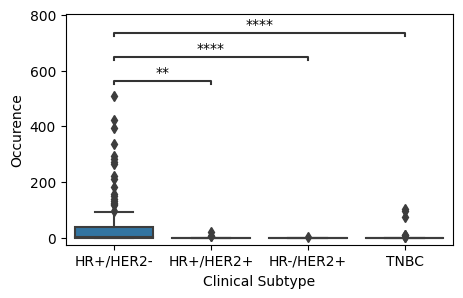

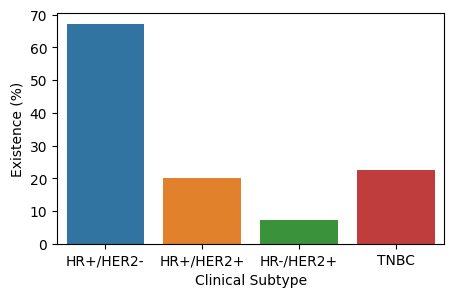

In [32]:
ER_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'ER Status'].values[0] for patient_id in Patient_IDs])
PR_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'PR Status'].values[0] for patient_id in Patient_IDs])
HER2_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'HER2 Status'].values[0] for patient_id in Patient_IDs])
Clinical_subtype = np.zeros(ER_status.shape, dtype=object)
for i in range(len(ER_status)):
    er= ER_status[i]
    pr= PR_status[i]
    her2= HER2_status[i]
    if (er == 'Positive' or pr == 'Positive') and her2 == 'Negative':
        Clinical_subtype[i] = 'HR+/HER2-'
    elif (er == 'Positive' or pr == 'Positive') and her2 == 'Positive':
        Clinical_subtype[i] = 'HR+/HER2+'
    elif (er == 'Negative' and pr == 'Negative') and her2 == 'Positive':
        Clinical_subtype[i] = 'HR-/HER2+'
    elif (er == 'Negative' and pr == 'Negative') and her2 == 'Negative':
        Clinical_subtype[i] = 'TNBC'
print("{} patients in total, {} HR+/HER2-, {} HR+/HER2+, {} HR-/HER2+, {} TNBC".format(len(Clinical_subtype),
np.sum(Clinical_subtype == 'HR+/HER2-'), np.sum(Clinical_subtype == 'HR+/HER2+'), np.sum(Clinical_subtype == 'HR-/HER2+'), np.sum(Clinical_subtype == 'TNBC')))

for pattern_id in Pattern_ids:
    histogram = Histograms[:, pattern_id-1]
    DF_presentation = pd.DataFrame({
        'Occurence': histogram,
        'Clinical Subtype': Clinical_subtype,
    })
    DF_presentation = DF_presentation.loc[DF_presentation['Clinical Subtype'] != 0]
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(x='Clinical Subtype', y='Occurence', data=DF_presentation, showfliers=True, order=['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC'])
    from statannotations.Annotator import Annotator
    annot = Annotator(
        ax,
        [("HR+/HER2-", "HR+/HER2+"), ("HR+/HER2-", "HR-/HER2+"), ("HR+/HER2-", "TNBC")],
        data=DF_presentation,
        x="Clinical Subtype",
        y="Occurence",
        order=["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
    )
    annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
    annot.apply_test()
    ax, test_results = annot.annotate()

    DF_existence = pd.DataFrame({
        'Clinical Subtype': ['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC'],
    })
    for clinical_subtype in ['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC']:
        data = DF_presentation.loc[DF_presentation['Clinical Subtype'] == clinical_subtype, 'Occurence'].values
        
        exisitence_ratio = np.sum(data > 0) / len(data)
        DF_existence.loc[DF_existence['Clinical Subtype'] == clinical_subtype, 'Existence (%)'] = exisitence_ratio*100
        print("Pattern {} in {} has {:.0f}% of patients".format(pattern_id, clinical_subtype, exisitence_ratio * 100))
    f, ax = plt.subplots(figsize=(5, 3))
    sns.barplot(x='Clinical Subtype', y='Existence (%)', data=DF_existence, order=['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC'])

### K-M plot

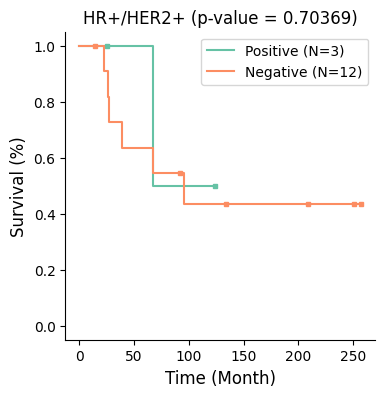

In [34]:
color_palette = sns.color_palette("Set2")
Length = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Disease-specific Survival (Months)"].values[0]
        for i in Patient_IDs
    ]
)
Status = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Disease-specific Survival Status"].values[0]
        for i in Patient_IDs
    ]
)

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

kmf = KaplanMeierFitter()
for clinical_subtype in ["HR+/HER2+"]:
    f, ax = plt.subplots(figsize=(4, 4))
    histogram = Histograms[:, Pattern_ids[0] - 1]
    length_A, event_observed_A = (
        Length[
            (Clinical_subtype == clinical_subtype)
            & (histogram > 0)
        ],
        Status[
            (Clinical_subtype == clinical_subtype)
            & (histogram > 0)
        ],
    )
    label = "Positive (N={})".format(len(length_A))
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[0],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

    length_B, event_observed_B = (
        Length[
            (Clinical_subtype == clinical_subtype)
            & (histogram == 0)
        ],
        Status[
            (Clinical_subtype == clinical_subtype)
            & (histogram == 0)
        ],
    )
    label = "Negative (N={})".format(len(length_B))
    kmf.fit(length_B, event_observed_B, label=label)
    kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[1],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )
    log_rank_test = multivariate_logrank_test(
        np.concatenate([length_A, length_B]),
        [0] * len(length_A) + [1] * len(length_B),
        np.concatenate([event_observed_A, event_observed_B]),
    )
    p_value = log_rank_test.p_value
    ax.legend(fontsize=10)
    ax.set_title("{} (p-value = {:.5f})".format(clinical_subtype, p_value), fontsize=12)
    ax.set_xlabel("Time (Month)", fontsize=12)
    ax.set_ylabel("Survival (%)", fontsize=12)
    ax.set(
        ylim=(-0.05, 1.05),
    )
    sns.despine()

# Jackson

### Clinical

In [15]:
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Jackson",
        "clinical.csv",
    )
)
clinical.head()
clinical.rename(columns={'ERStatus': 'ER Status'}, inplace=True)
clinical.rename(columns={'HER2Status': 'HER2 Status'}, inplace=True)
clinical.rename(columns={'PRStatus': 'PR Status'}, inplace=True)
clinical['ER Status'] = clinical['ER Status'].map({'positive': 'Positive', 'negative': 'Negative'})
clinical['HER2 Status'] = clinical['HER2 Status'].map({'positive': 'Positive', 'negative': 'Negative'})
clinical['PR Status'] = clinical['PR Status'].map({'positive': 'Positive', 'negative': 'Negative'})
clinical['Overall Survival Status'] = clinical['Overall Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})

### Histogram

In [16]:
SoftWL_dict = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Jackson",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            +'_'
            +str(node_label)
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)

Histograms = SoftWL_dict["Histogram"]
Patient_IDs = SoftWL_dict["Patient_id"]

### Presentation in 4 clinical subtypes

266 patients in total, 173 HR+/HER2-, 25 HR+/HER2+, 22 HR-/HER2+, 45 TNBC
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HR+/HER2- vs. HR+/HER2+: Mann-Whitney-Wilcoxon test two-sided, P_val:2.518e-02 U_stat=2.736e+03
HR+/HER2- vs. HR-/HER2+: Mann-Whitney-Wilcoxon test two-sided, P_val:3.270e-03 U_stat=2.601e+03
HR+/HER2- vs. TNBC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.809e-04 U_stat=5.223e+03
Pattern 6 in HR+/HER2- has 58% of patients
Pattern 6 in HR+/HER2+ has 36% of patients
Pattern 6 in HR-/HER2+ has 23% of patients
Pattern 6 in TNBC has 27% of patients


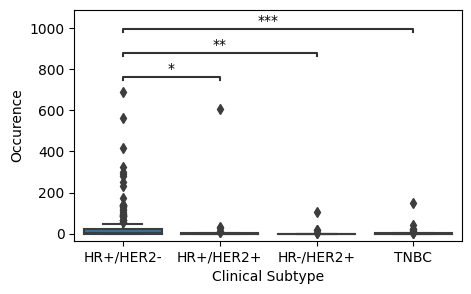

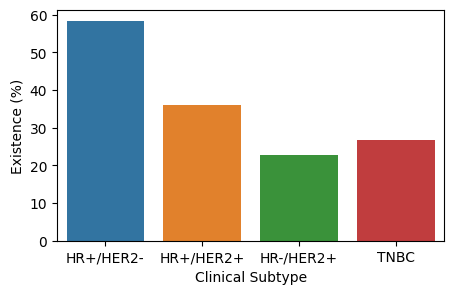

In [17]:

ER_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'ER Status'].values[0] for patient_id in Patient_IDs])
PR_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'PR Status'].values[0] for patient_id in Patient_IDs])
HER2_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'HER2 Status'].values[0] for patient_id in Patient_IDs])
Clinical_subtype = np.zeros(ER_status.shape, dtype=object)
for i in range(len(ER_status)):
    er= ER_status[i]
    pr= PR_status[i]
    her2= HER2_status[i]
    if (er == 'Positive' or pr == 'Positive') and her2 == 'Negative':
        Clinical_subtype[i] = 'HR+/HER2-'
    elif (er == 'Positive' or pr == 'Positive') and her2 == 'Positive':
        Clinical_subtype[i] = 'HR+/HER2+'
    elif (er == 'Negative' and pr == 'Negative') and her2 == 'Positive':
        Clinical_subtype[i] = 'HR-/HER2+'
    elif (er == 'Negative' and pr == 'Negative') and her2 == 'Negative':
        Clinical_subtype[i] = 'TNBC'
print("{} patients in total, {} HR+/HER2-, {} HR+/HER2+, {} HR-/HER2+, {} TNBC".format(len(Clinical_subtype),
np.sum(Clinical_subtype == 'HR+/HER2-'), np.sum(Clinical_subtype == 'HR+/HER2+'), np.sum(Clinical_subtype == 'HR-/HER2+'), np.sum(Clinical_subtype == 'TNBC')))

for pattern_id in Pattern_ids:
    histogram = Histograms[:, pattern_id-1]
    DF_presentation = pd.DataFrame({
        'Occurence': histogram,
        'Clinical Subtype': Clinical_subtype,
    })
    DF_presentation = DF_presentation.loc[DF_presentation['Clinical Subtype'] != 0]
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(x='Clinical Subtype', y='Occurence', data=DF_presentation, showfliers=True, order=['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC'])
    from statannotations.Annotator import Annotator
    annot = Annotator(
        ax,
        [("HR+/HER2-", "HR+/HER2+"), ("HR+/HER2-", "HR-/HER2+"), ("HR+/HER2-", "TNBC")],
        data=DF_presentation,
        x="Clinical Subtype",
        y="Occurence",
        order=["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
    )
    annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
    annot.apply_test()
    ax, test_results = annot.annotate()

    DF_existence = pd.DataFrame({
        'Clinical Subtype': ['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC'],
    })
    for clinical_subtype in ['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC']:
        data = DF_presentation.loc[DF_presentation['Clinical Subtype'] == clinical_subtype, 'Occurence'].values
        
        exisitence_ratio = np.sum(data > 0) / len(data)
        DF_existence.loc[DF_existence['Clinical Subtype'] == clinical_subtype, 'Existence (%)'] = exisitence_ratio*100
        print("Pattern {} in {} has {:.0f}% of patients".format(pattern_id, clinical_subtype, exisitence_ratio * 100))
    f, ax = plt.subplots(figsize=(5, 3))
    sns.barplot(x='Clinical Subtype', y='Existence (%)', data=DF_existence, order=['HR+/HER2-', 'HR+/HER2+', 'HR-/HER2+', 'TNBC'])

### K-M Plot

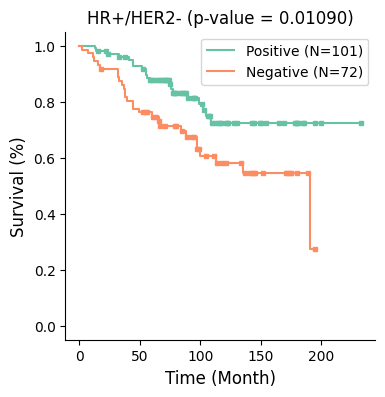

In [19]:
color_palette = sns.color_palette("Set2")
Length = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Overall Survival (Months)"].values[0]
        for i in Patient_IDs
    ]
)
Status = np.array(
    [
        clinical.loc[clinical["patient_id"] == i, "Overall Survival Status"].values[0]
        for i in Patient_IDs
    ]
)

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

kmf = KaplanMeierFitter()
for clinical_subtype in ["HR+/HER2-"]:
    f, ax = plt.subplots(figsize=(4, 4))
    histogram = Histograms[:, Pattern_ids[0] - 1]
    length_A, event_observed_A = (
        Length[
            (Clinical_subtype == clinical_subtype)
            & (histogram > 0)
        ],
        Status[
            (Clinical_subtype == clinical_subtype)
            & (histogram > 0)
        ],
    )
    label = "Positive (N={})".format(len(length_A))
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[0],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

    length_B, event_observed_B = (
        Length[
            (Clinical_subtype == clinical_subtype)
            & (Histograms[:, Pattern_ids[0] - 1] == 0)
        ],
        Status[
            (Clinical_subtype == clinical_subtype)
            & (Histograms[:, Pattern_ids[0] - 1] == 0)
        ],
    )
    label = "Negative (N={})".format(len(length_B))
    kmf.fit(length_B, event_observed_B, label=label)
    kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette[1],
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )
    log_rank_test = multivariate_logrank_test(
        np.concatenate([length_A, length_B]),
        [0] * len(length_A) + [1] * len(length_B),
        np.concatenate([event_observed_A, event_observed_B]),
    )
    p_value = log_rank_test.p_value
    ax.legend(fontsize=10)
    ax.set_title("{} (p-value = {:.5f})".format(clinical_subtype, p_value), fontsize=12)
    ax.set_xlabel("Time (Month)", fontsize=12)
    ax.set_ylabel("Survival (%)", fontsize=12)
    ax.set(
        ylim=(-0.05, 1.05),
    )
    sns.despine()